In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
iamsouravbanerjee_indian_food_images_dataset_path = kagglehub.dataset_download('iamsouravbanerjee/indian-food-images-dataset')

print('Data source import complete.')


100%|██████████| 355M/355M [00:06<00:00, 55.5MB/s]

Extracting files...


Data source import complete.


In [2]:
# prompt: save above dataset in content dir

import shutil
import os

# Assuming iamsouravbanerjee_indian_food_images_dataset_path is defined as in the provided code.
# If not, replace with the actual path to the downloaded dataset.


# Define the destination directory within the content directory.
destination_dir = "/content/indian_food_images"

# Create the destination directory if it doesn't exist.
os.makedirs(destination_dir, exist_ok=True)

# Move the downloaded dataset to the specified destination.
shutil.move(iamsouravbanerjee_indian_food_images_dataset_path, destination_dir)

print(f"Dataset moved to: {destination_dir}")


Dataset moved to: /content/indian_food_images


## Dataset Overview

**Context**
Indian cuisine consists of a variety of regional and traditional cuisines native to the Indian subcontinent. Given the diversity in soil, climate, culture, ethnic groups, and occupations, these cuisines vary substantially and use locally available spices, herbs, vegetables, and fruits. Indian food is also heavily influenced by religion, in particular Hinduism, cultural choices, and traditions. Centuries of Islamic rule, particularly by the Mughals, also introduced dishes like samosa and pilaf.

Historical events such as invasions, trade relations, and colonialism have played a role in introducing certain foods to this country. The Columbian discovery of the New World brought a number of new vegetables and fruit to India. A number of these such as the potato, tomatoes, chilies, peanuts, and Guava have become staples in many regions of India. Indian cuisine has shaped the history of international relations; the spice trade between India and Europe was the primary catalyst for Europe's Age of Discovery. Spices were bought from India and traded around Europe and Asia. Indian cuisine has influenced other cuisines across the world, especially those from Europe (especially Britain), the Middle East, Southern African, East Africa, Southeast Asia, North America, Mauritius, Fiji, Oceania, and the Caribbean.

**Content**
In this Dataset, we have 4000 Indian Food Images in 80 different categories or classes.

## Importing libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D,MaxPooling2D,Flatten,InputLayer,AveragePooling2D
from keras.layers import BatchNormalization,Dropout,Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50,MobileNetV2
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score, recall_score
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.applications.mobilenet_v2 import preprocess_input
import pickle

In [4]:
!pip install efficientnet
!pip install keras-applications

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00


## Dataframe creation

In [5]:
path = '/content/indian_food_images/5/Indian Food Images/Indian Food Images'

labels = os.listdir(path)
df = pd.DataFrame(columns=['img_path','label'])

for label in labels:
    img_dir_path = os.path.join(path,label)
    for img in os.listdir(img_dir_path):
        img_path = os.path.join(img_dir_path,img)
        df.loc[df.shape[0]] = [img_path,label]

# shuffling dataset
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
df.head()

,img_path,label
0,/content/indian_food_images/5/Indian Food Imag...,palak_paneer
1,/content/indian_food_images/5/Indian Food Imag...,palak_paneer
2,/content/indian_food_images/5/Indian Food Imag...,imarti
3,/content/indian_food_images/5/Indian Food Imag...,boondi
4,/content/indian_food_images/5/Indian Food Imag...,sandesh


In [7]:
print("Number of images",df.shape[0])
print("Number of labels",df['label'].nunique())

print('There are only 50 images per calss')

Number of images 4000
Number of labels 80
There are only 50 images per calss


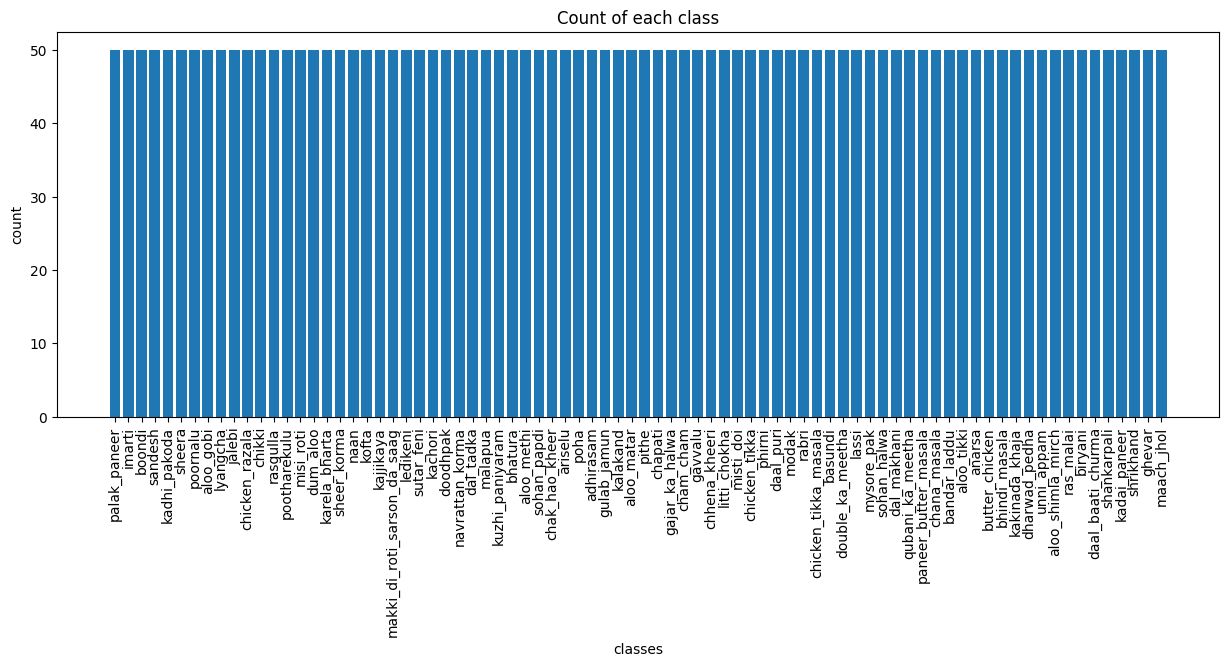

In [8]:
plt.figure(figsize=(15,5))
plt.bar(x = df['label'].unique(),height=df['label'].value_counts())
plt.xlabel('classes')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.title('Count of each class')
plt.show()

Each class have same no. of images and there is no imbalance

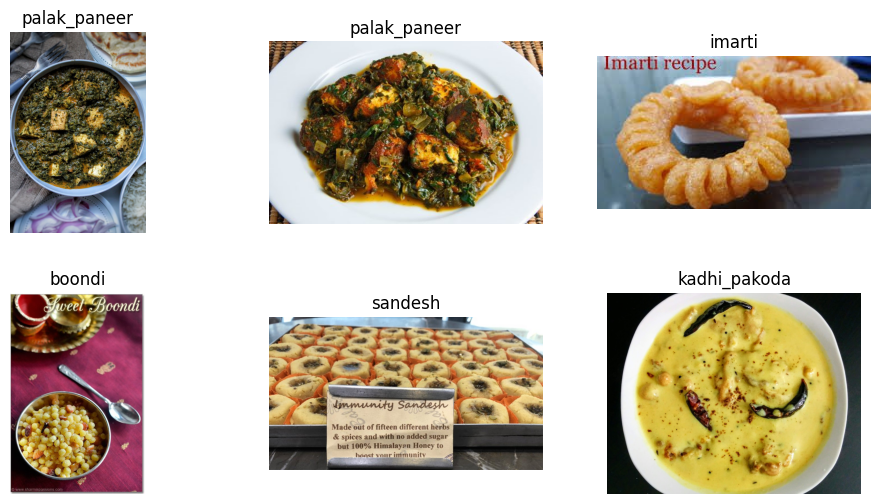

In [9]:
plt.figure(figsize=(12,6))

for i in range(1,3):
    for j in range(1,4):
        plt.subplot(2,3,3*(i-1) + j)
        img_data = cv2.imread(df['img_path'][3*(i-1) + (j-1)])
        image_rgb = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB) # BGR to RGB format
        plt.imshow(image_rgb)
        plt.title(df['label'][3*(i-1) + (j-1)])
        plt.axis('off')

plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

## Train test split

In [10]:
x_train,x_val , y_train,y_val = train_test_split(df['img_path'],df['label'],random_state=42,test_size=0.2)

## Augmentation

In [11]:
def preprocess(img_paths):
    images = []
    for img_path in img_paths:
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_resized = cv2.resize(image_rgb, (224, 224))
        image_normalized = image_resized.astype('float32') / 255
        images.append(image_normalized)
    return np.array(images)

In [12]:
datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale pixel values to [0, 1]
    rotation_range=20,         # Degree range for random rotations
    width_shift_range=0.2,     # Fraction of total width to shift images horizontally
    height_shift_range=0.2,    # Fraction of total height to shift images vertically
    shear_range=0.2,           # Shear angle in counter-clockwise direction
    zoom_range=0.2,            # Range for random zoom
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Strategy for filling in newly created pixels
)

train_dataset = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'img_path':x_train,'label':y_train}),
    x_col='img_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='training'
)


Found 3200 validated image filenames belonging to 80 classes.


In [13]:
class_indices = train_dataset.class_indices

# Print the class indices dictionary
print("Class Indices:")
print(class_indices)

Class Indices:
{'adhirasam': 0, 'aloo_gobi': 1, 'aloo_matar': 2, 'aloo_methi': 3, 'aloo_shimla_mirch': 4, 'aloo_tikki': 5, 'anarsa': 6, 'ariselu': 7, 'bandar_laddu': 8, 'basundi': 9, 'bhatura': 10, 'bhindi_masala': 11, 'biryani': 12, 'boondi': 13, 'butter_chicken': 14, 'chak_hao_kheer': 15, 'cham_cham': 16, 'chana_masala': 17, 'chapati': 18, 'chhena_kheeri': 19, 'chicken_razala': 20, 'chicken_tikka': 21, 'chicken_tikka_masala': 22, 'chikki': 23, 'daal_baati_churma': 24, 'daal_puri': 25, 'dal_makhani': 26, 'dal_tadka': 27, 'dharwad_pedha': 28, 'doodhpak': 29, 'double_ka_meetha': 30, 'dum_aloo': 31, 'gajar_ka_halwa': 32, 'gavvalu': 33, 'ghevar': 34, 'gulab_jamun': 35, 'imarti': 36, 'jalebi': 37, 'kachori': 38, 'kadai_paneer': 39, 'kadhi_pakoda': 40, 'kajjikaya': 41, 'kakinada_khaja': 42, 'kalakand': 43, 'karela_bharta': 44, 'kofta': 45, 'kuzhi_paniyaram': 46, 'lassi': 47, 'ledikeni': 48, 'litti_chokha': 49, 'lyangcha': 50, 'maach_jhol': 51, 'makki_di_roti_sarson_da_saag': 52, 'malapua': 

## index_to_class dictionary

In [15]:
index_to_class = {v: k for k, v in class_indices.items()}
print("Index to Class Mapping:")
print(index_to_class)

Index to Class Mapping:
{0: 'adhirasam', 1: 'aloo_gobi', 2: 'aloo_matar', 3: 'aloo_methi', 4: 'aloo_shimla_mirch', 5: 'aloo_tikki', 6: 'anarsa', 7: 'ariselu', 8: 'bandar_laddu', 9: 'basundi', 10: 'bhatura', 11: 'bhindi_masala', 12: 'biryani', 13: 'boondi', 14: 'butter_chicken', 15: 'chak_hao_kheer', 16: 'cham_cham', 17: 'chana_masala', 18: 'chapati', 19: 'chhena_kheeri', 20: 'chicken_razala', 21: 'chicken_tikka', 22: 'chicken_tikka_masala', 23: 'chikki', 24: 'daal_baati_churma', 25: 'daal_puri', 26: 'dal_makhani', 27: 'dal_tadka', 28: 'dharwad_pedha', 29: 'doodhpak', 30: 'double_ka_meetha', 31: 'dum_aloo', 32: 'gajar_ka_halwa', 33: 'gavvalu', 34: 'ghevar', 35: 'gulab_jamun', 36: 'imarti', 37: 'jalebi', 38: 'kachori', 39: 'kadai_paneer', 40: 'kadhi_pakoda', 41: 'kajjikaya', 42: 'kakinada_khaja', 43: 'kalakand', 44: 'karela_bharta', 45: 'kofta', 46: 'kuzhi_paniyaram', 47: 'lassi', 48: 'ledikeni', 49: 'litti_chokha', 50: 'lyangcha', 51: 'maach_jhol', 52: 'makki_di_roti_sarson_da_saag', 53

## Model Training

In [14]:
def build_model(base):
    base_model = base
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        Flatten(),

        Dense(256, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),

        Dense(128, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),

        Dense(80, activation='softmax'),  # For binary classification
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### MobileNetV2

In [ ]:
mobilenet_model = build_model(MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
history_mobilenet = mobilenet_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // 32,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

In [16]:


import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0 # You can choose other EfficientNet variants
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# ... (Your existing code for data loading and preprocessing) ...

def build_efficientnet_model(num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)  # Adjust units as needed
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build the EfficientNet model
efficientnet_model = build_efficientnet_model(num_classes=80)  # Set the number of classes

# Train the model
history_efficientnet = efficientnet_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // 32,
    epochs=10  # Adjust the number of epochs as needed
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 145s 584ms/step - accuracy: 0.1706 - loss: 3.5940
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 509ms/step - accuracy: 0.5293 - loss: 1.6708
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 139us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 508ms/step - accuracy: 0.6644 - loss: 1.1203
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 490ms/step - accuracy: 0.7473 - loss: 0.8137
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 140us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 54s 507ms/step - accuracy: 0.7993 - loss: 0.6486
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 139us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Resizing # Import Resizing layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ... (Your existing code for data loading and preprocessing) ...

def build_nasnetmobile_model(num_classes):
    base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Add a Resizing layer to the beginning of the model
    input_tensor = tf.keras.Input(shape=(331, 331, 3))  # Input shape from your train_dataset
    resized_input = Resizing(224, 224)(input_tensor)

    x = base_model(resized_input)  # Pass the resized input to the base model
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add dropout for regularization
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=predictions) # Update model inputs

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build the NASNetMobile model
nasnetmobile_model = build_nasnetmobile_model(num_classes=80)

# Train the model
history_nasnetmobile = nasnetmobile_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // 32,
    epochs=10  # Adjust the number of epochs as needed
)

### InceptionV3

In [ ]:
# inceptionv3_model = build_model(InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
# history_inception = inceptionv3_model.fit(
#     train_dataset,
#     steps_per_epoch=train_dataset.samples // 32,
#     epochs=10,
# )

### ResNet50

In [ ]:
# resnet50_model = build_model(ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
# history_resnet = resnet50_model.fit(
#     train_dataset,
#     steps_per_epoch=train_dataset.samples // 32,
#     epochs=10,
# )

In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['loss'], label='MobileNetV2')
plt.plot(history_inception.history['loss'], label='Inception')
plt.plot(history_resnet.history['loss'], label='ResNet')
plt.plot(history_efficientnet.history['loss'], label='EfficientNet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['accuracy'], label='MobileNetV2')
plt.plot(history_inception.history['accuracy'], label='Inception')
plt.plot(history_resnet.history['accuracy'], label='ResNet')
plt.plot(history_efficientnet.history['accuracy'], label='EfficientNet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Fine tuning

In [17]:
# prompt: can you generate new model from mergeing above models

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Resizing
from tensorflow.keras.optimizers import Adam
from efficientnet.tfkeras import EfficientNetB0
from keras_applications.nasnet import NASNetMobile

# ... (Your existing code for data loading and preprocessing) ...

def build_ensemble_model(models, num_classes):
    """Builds an ensemble model by averaging the predictions of multiple models."""

    # Create input layer
    input_tensor = tf.keras.Input(shape=(224, 224, 3))  # Assumes input shape (224, 224, 3)

    # Get outputs from individual models
    outputs = [model(input_tensor) for model in models]

    # Average the predictions
    averaged_output = tf.keras.layers.Average()(outputs)

    # Add a final classification layer
    predictions = Dense(num_classes, activation='softmax')(averaged_output)

    # Create and compile the ensemble model
    ensemble_model = Model(inputs=input_tensor, outputs=predictions)
    ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return ensemble_model

# Get the trained models
# mobilenet_model = mobilenet_model  # Assuming mobilenet_model is defined
# inceptionv3_model = inceptionv3_model # Assuming inceptionv3_model is defined
# resnet50_model = resnet50_model # Assuming resnet50_model is defined
# efficientnet_model = efficientnet_model # Assuming efficientnet_model is defined


# Create the ensemble model
models = [mobilenet_model efficientnet_model]
ensemble_model = build_ensemble_model(models, num_classes=80)

# Train the ensemble model (if needed, or load pre-trained weights)
history_ensemble = ensemble_model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // 32,
    epochs=10  # Adjust epochs as needed
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-17-c86473753a82>, line 39)

In [ ]:
# prompt: save this model in pickle

import pickle

# Assuming ensemble_model is your trained model
filename = 'ensemble_model.sav'
pickle.dump(ensemble_model, open(filename, 'wb'))

In [ ]:
# prompt: I want to use this model to find the area of food not class prediction

import cv2
import numpy as np

def calculate_food_area(image_path):
    """
    Calculates the approximate area of food in an image.

    Args:
        image_path: Path to the image file.

    Returns:
        The approximate area of food in pixels, or -1 if an error occurs.
    """
    try:
        # Load the image using OpenCV
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not load image at {image_path}")
            return -1

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Perform adaptive thresholding to segment the food
        thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)


        # Find contours of the segmented food
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Calculate the total area of all contours (food regions)
        total_area = 0
        for contour in contours:
            total_area += cv2.contourArea(contour)

        return total_area
    except Exception as e:
        print(f"An error occurred: {e}")
        return -1


# Example usage:
# Assuming 'df' is your DataFrame with 'img_path' column
# Iterate through the dataframe and calculate the food area for each image
for index, row in df.iterrows():
    image_path = row['img_path']
    food_area = calculate_food_area(image_path)
    print(f"Image: {image_path}, Food Area: {food_area} pixels")

    # You can add a new column to the DataFrame to store food area
    df.loc[index, 'food_area'] = food_area

In [18]:
final_base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [19]:
layer_list = (final_base_model.layers)
layer_list.reverse()

flag = True
for layers in layer_list:
    if flag:layers.trainable=True
    else:layers.trainable=False
    if 'Conv_1' in layers.name:flag = False

In [20]:
base_model = final_base_model

final_model = Sequential([
        base_model,
        Flatten(),

        Dense(256, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),

        Dense(128, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),

        Dense(80, activation='softmax'),  # For binary classification
    ])

final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history_final = final_model.fit(
    train_dataset,
    steps_per_epoch=100,
    epochs=30,
)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 122s 455ms/step - accuracy: 0.0349 - loss: 4.6633
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 107s 476ms/step - accuracy: 0.1397 - loss: 3.6565
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 142us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 475ms/step - accuracy: 0.2742 - loss: 2.9157
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 167us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - accuracy: 0.3881 - loss: 2.3679
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 149us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 470ms/step - accuracy: 0.4693 - loss: 1.9743
Epoch 10/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 142us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 467ms/step - accuracy: 0.54

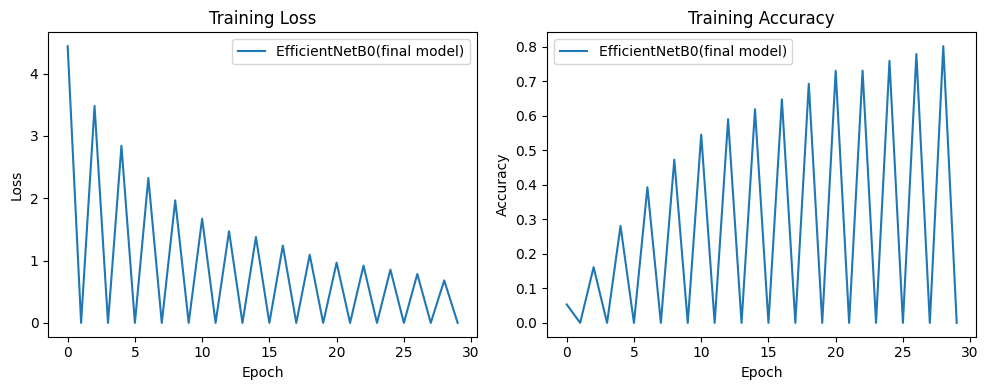

In [22]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_final.history['loss'], label='EfficientNetB0(final model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_final.history['accuracy'], label='EfficientNetB0(final model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Validation and Accuracy

In [23]:
# finding y_pred using x_val
y_pred = []
for img_path in x_val:
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    predictions = final_model.predict(img_array,verbose=False)
    predicted_class_index = np.argmax(predictions)
    y_pred.append(index_to_class[predicted_class_index])


In [24]:
print(f"validation accuracy : {accuracy_score(y_val,y_pred)}")

validation accuracy : 0.38375


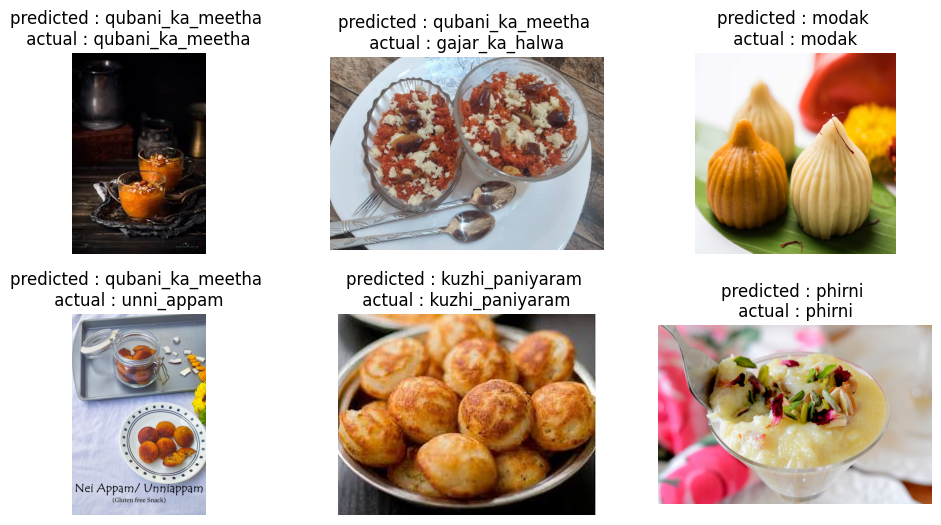

In [25]:
plt.figure(figsize=(12,6))

for i in range(1,3):
    for j in range(1,4):
        plt.subplot(2,3,3*(i-1) + j)
        image = cv2.imread(x_val.values[3*(i-1) + (j-1)])
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR to RGB format
        plt.imshow(image_rgb)
        plt.title(f"predicted : {y_pred[3*(i-1) + (j-1)]} \n actual : {y_val.values[3*(i-1) + (j-1)]} ")
        plt.axis('off')

plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

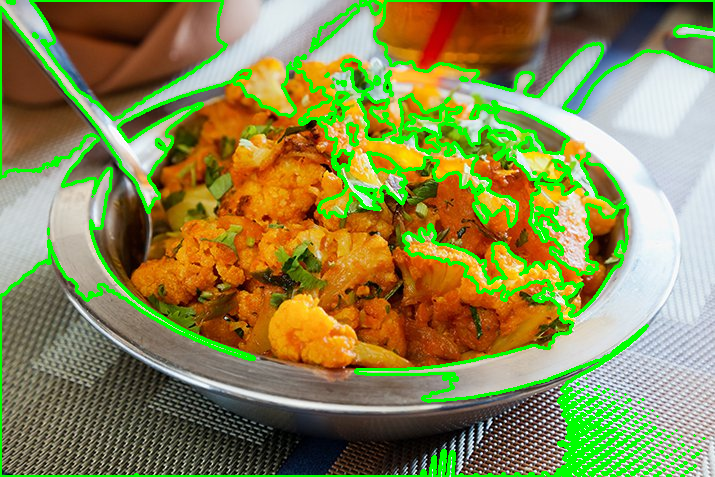

Total Food Area: 220052.0 pixels


In [26]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow # Import cv2_imshow


def calculate_food_area(image_path):
    # Step 1: Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not read the image.")
        return None

    # Step 2: Preprocess the image
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Thresholding to get a binary mask
    _, binary_mask = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY_INV)

    # Step 3: Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 4: Calculate the area of each contour
    total_area = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        total_area += area

    # Optionally, display the results
    cv2.drawContours(image, contours, -1, (0, 255, 0), 2)  # Draw contours on the original image
    # cv2.putText(image, f"Total Food Area: {total_area} pixels", (10, 30),
    #             cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Show the image with contours
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return total_area

# Example usage
image_path = '/content/indian_food_images/5/Indian Food Images/Indian Food Images/aloo_gobi/00fce13f41.jpg'
food_area = calculate_food_area(image_path)
print(f"Total Food Area: {food_area} pixels")

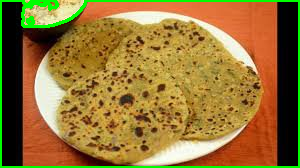

Total Food Area: 48753.5 pixels


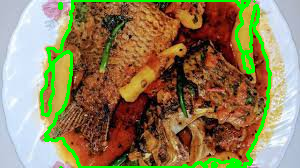

Total Food Area: 32032.5 pixels


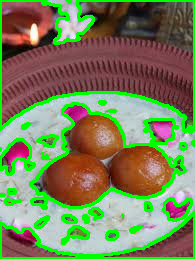

Total Food Area: 32907.5 pixels


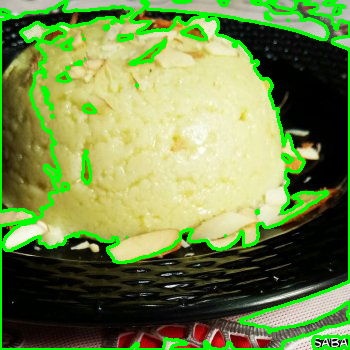

Total Food Area: 62673.5 pixels


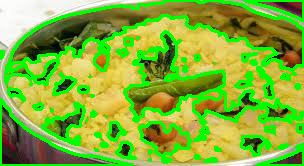

Total Food Area: 21257.5 pixels


In [27]:
# prompt: perform above analysis on randon 5 images

import random
image_paths = random.sample(list(df['img_path']),5)

for image_path in image_paths:
    food_area = calculate_food_area(image_path)
    df.loc[df['img_path'] == image_path, 'food_area'] = food_area
    print(f"Total Food Area: {food_area} pixels")

## Confusion matrix

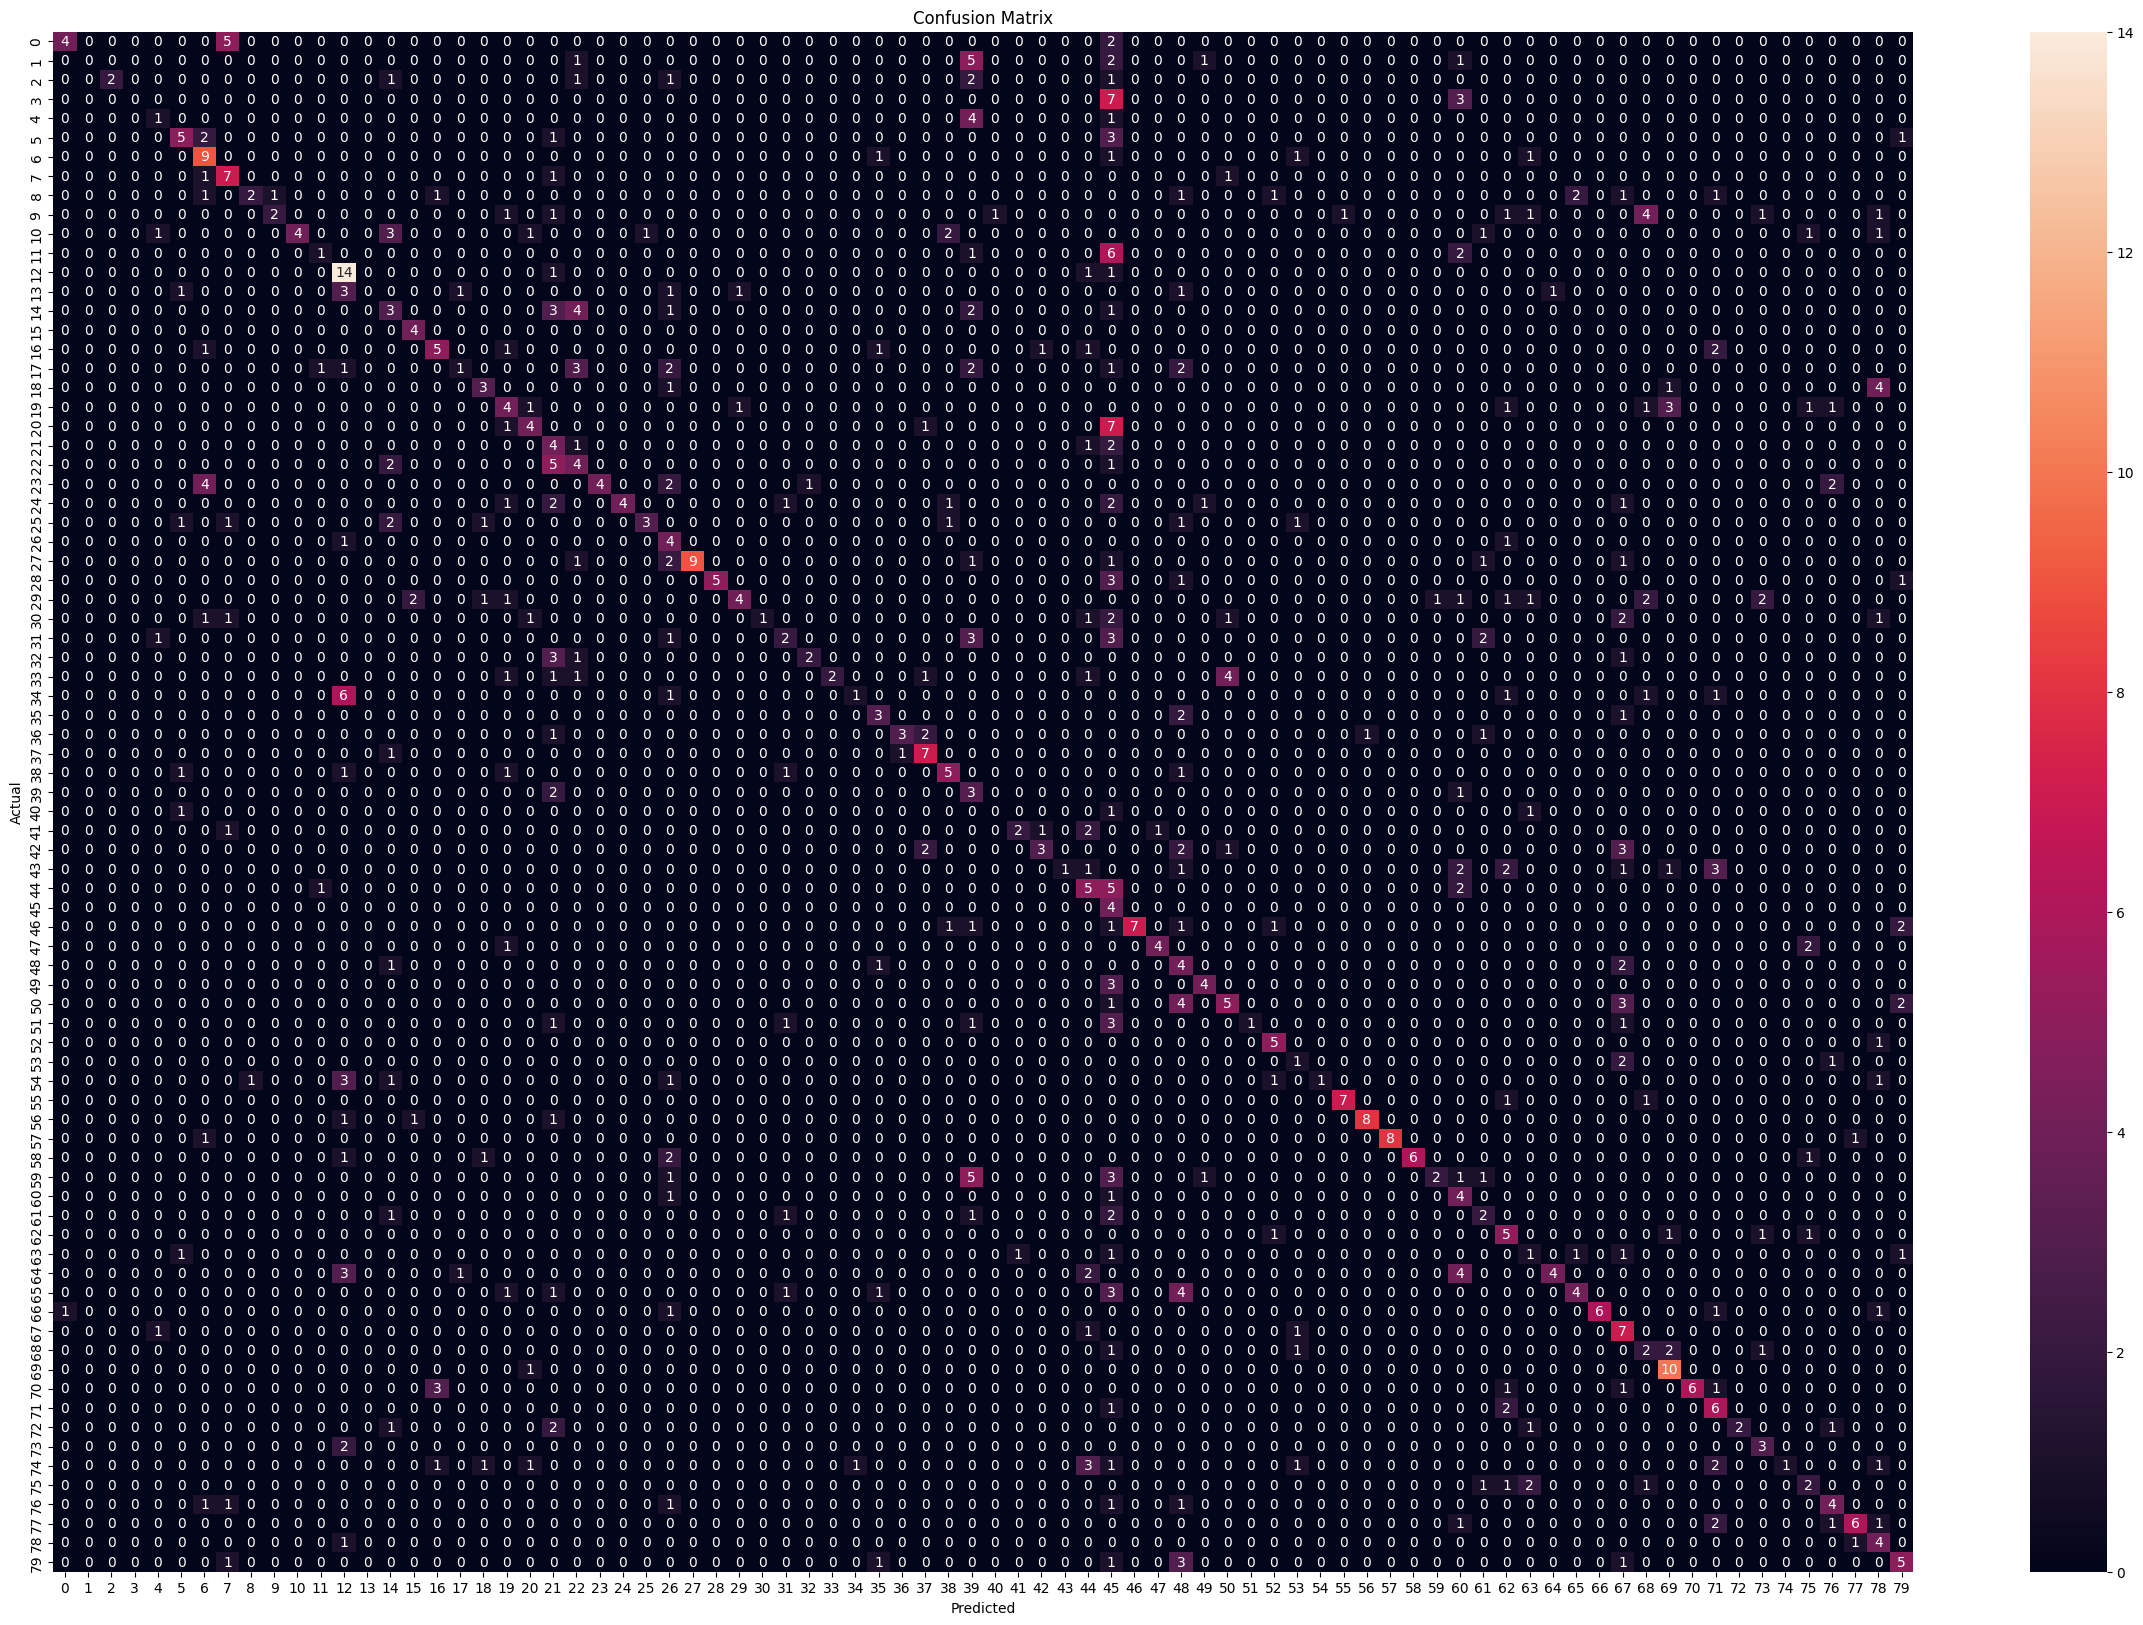

In [30]:
plt.figure(figsize=(30,20))
sns.heatmap(confusion_matrix(y_val,y_pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Classification report

In [28]:
print(classification_report(y_val,y_pred))

                              precision    recall  f1-score   support

                   adhirasam       0.80      0.36      0.50        11
                   aloo_gobi       0.00      0.00      0.00        10
                  aloo_matar       1.00      0.25      0.40         8
                  aloo_methi       0.00      0.00      0.00        10
           aloo_shimla_mirch       0.25      0.17      0.20         6
                  aloo_tikki       0.50      0.42      0.45        12
                      anarsa       0.43      0.69      0.53        13
                     ariselu       0.41      0.70      0.52        10
                bandar_laddu       0.67      0.18      0.29        11
                     basundi       0.67      0.14      0.24        14
                     bhatura       1.00      0.27      0.42        15
               bhindi_masala       0.33      0.10      0.15        10
                     biryani       0.38      0.82      0.52        17
                   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
# prompt: f1, recall and accuracy of final_model

from sklearn.metrics import f1_score, recall_score, accuracy_score

# Assuming y_val and y_pred are defined from your previous code
f1 = f1_score(y_val, y_pred, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_val, y_pred, average='weighted')
accuracy = accuracy_score(y_val, y_pred)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

F1 Score: 0.39316348391763367
Recall: 0.38375
Accuracy: 0.38375


In [33]:

import pickle
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [ ]:
# prompt: write algorithm for this whole file for a research paper

# Algorithm for Indian Food Image Classification and Food Area Estimation

## 1. Data Loading and Preprocessing

# 1.1. Load image data from the specified directory.
# 1.2. Create a Pandas DataFrame to store image paths and corresponding labels.
# 1.3. Shuffle the DataFrame randomly.

## 2. Exploratory Data Analysis (EDA)

# 2.1. Display the number of images and unique labels in the dataset.
# 2.2. Visualize the distribution of classes (number of images per class).
# 2.3. Display sample images with their corresponding labels.

## 3. Data Splitting

# 3.1. Split the dataset into training and validation sets using train_test_split.

## 4. Data Augmentation

# 4.1. Use ImageDataGenerator to augment the training images.  Apply transformations such as
#      rotation, width/height shifting, shearing, zooming, horizontal flipping.
# 4.2. Create a training dataset from the augmented data.

## 5. Model Building and Training

# 5.1. Define a function `build_model` that creates a convolutional neural network model using a specified
#      pre-trained base model (e.g., MobileNetV2, EfficientNet, InceptionV3, ResNet50).
# 5.2. Freeze the base model's layers initially.
# 5.3. Add a classification head with Flatten, Dense, Dropout, and BatchNormalization layers.
# 5.4. Compile the model with an optimizer (Adam), loss function (categorical_crossentropy),
#      and accuracy metric.
# 5.5. Train multiple models using different base models (MobileNetV2, EfficientNet, and NASNetMobile are explicitly used in this code).
# 5.6. Save the trained model.  In this code, the ensemble model is saved.

## 6. Ensemble Learning

# 6.1. Define a function to create an ensemble model that averages predictions from multiple models.
# 6.2. Combine multiple trained models into an ensemble.


## 7. Food Area Calculation

# 7.1. Define a function `calculate_food_area` that takes an image path as input.
# 7.2. Load the image using OpenCV.
# 7.3. Convert the image to grayscale.
# 7.4. Apply Gaussian blur to reduce noise.
# 7.5. Use adaptive thresholding to create a binary mask of the food.
# 7.6. Find contours of the food regions in the binary mask.
# 7.7. Calculate the total area of all food contours.
# 7.8. Add a new column 'food_area' to the DataFrame to store the calculated area.


## 8. Model Fine-tuning

# 8.1. Unfreeze specific layers of the EfficientNet model.  The training is done from last convolutional layers to the first ones.
# 8.2. Recompile the model, as needed, with the chosen optimizer and loss functions.
# 8.3. Retrain the model on the training dataset, starting from the fine-tuning point.

## 9. Model Evaluation

# 9.1. Make predictions on the validation dataset.
# 9.2. Calculate and display the validation accuracy.
# 9.3. Display sample predictions along with actual labels.
# 9.4. Generate a confusion matrix to visualize the model's performance.
# 9.5. Produce a classification report containing precision, recall, F1-score, and support.
# 9.6 Calculate and print out relevant metrics, like F1 score, recall, and accuracy


## 10.  Additional image processing

# 10.1  Call calculate_food_area for specific images
# 10.2  Store the calculated areas in the Dataframe

